In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import ImageFolder
from config import CFG
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import math


In [2]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1] 범위로 변환
    
])

train_dataset=ImageFolder(root='C:/Users/admin/Desktop/VSC/custom_AI_data',
                     transform=transform)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True)


In [3]:
class DiffusionModel:
    def __init__(self,start_schedule=0.0001, end_scedule=0.02,timesteps=1000):
        self.start_schedule=start_schedule
        self.end_scedule=end_scedule
        self.timesteps=timesteps

        self.betas=torch.linspace(start_schedule,end_scedule,timesteps)
        self.alphas=1-self.betas
        self.alphas_cumprod=torch.cumprod(self.alphas,axis=0) #누적곱

    def forward(self,x_0,t,device):

        noise=torch.randn_like(x_0)
        sqrt_alphas_cumprod_t=self.get_index_from_list(self.alphas_cumprod.sqrt(),t,x_0.shape)
        sqrt_one_minus_alphas_cumprod_t=self.get_index_from_list(torch.sqrt(1.-self.alphas_cumprod),t,x_0.shape)

        mean=sqrt_alphas_cumprod_t.to(device)*x_0.to(device)
        variance=sqrt_one_minus_alphas_cumprod_t.to(device)*noise.to(device)

        return mean+variance,noise.to(device)
    
    def backward(self,x,t,model,**kwargs):
        betas_t=self.get_index_from_list(self.betas,t,x.shape)
        sqrt_one_minus_alphas_comprod_t=self.get_index_from_list(torch.sqrt(1.-self.alphas_cumprod),t,x.shape)
        sqrt_recip_alhas_t=self.get_index_from_list(torch.sqrt(1.0/self.alphas),t,x.shape)

        mean=sqrt_recip_alhas_t*(x-betas_t*model(x,t,**kwargs)/sqrt_one_minus_alphas_comprod_t)
        posterior_variance_t=betas_t

        if t==0:
            return mean
        else:
            noise=torch.randn_like(x)
            variance=torch.sqrt(posterior_variance_t)*noise
            return mean+variance
    @staticmethod
    def get_index_from_list(values,t,x_shape):
        batch_size=t.shape[0]
        

        result=values.gather(-1,t.cpu())
       
        """
        batch_size=5
        result: 5
        len(x_shape)=4
        
        """

        return result.reshape(batch_size,*((1,)*(len(x_shape)-1))).to(t.device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95085734..0.95356137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4336152..2.9462514].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6374106..3.9347894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.171758..4.260505].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.764324..4.014265].


<Figure size 1500x1500 with 0 Axes>

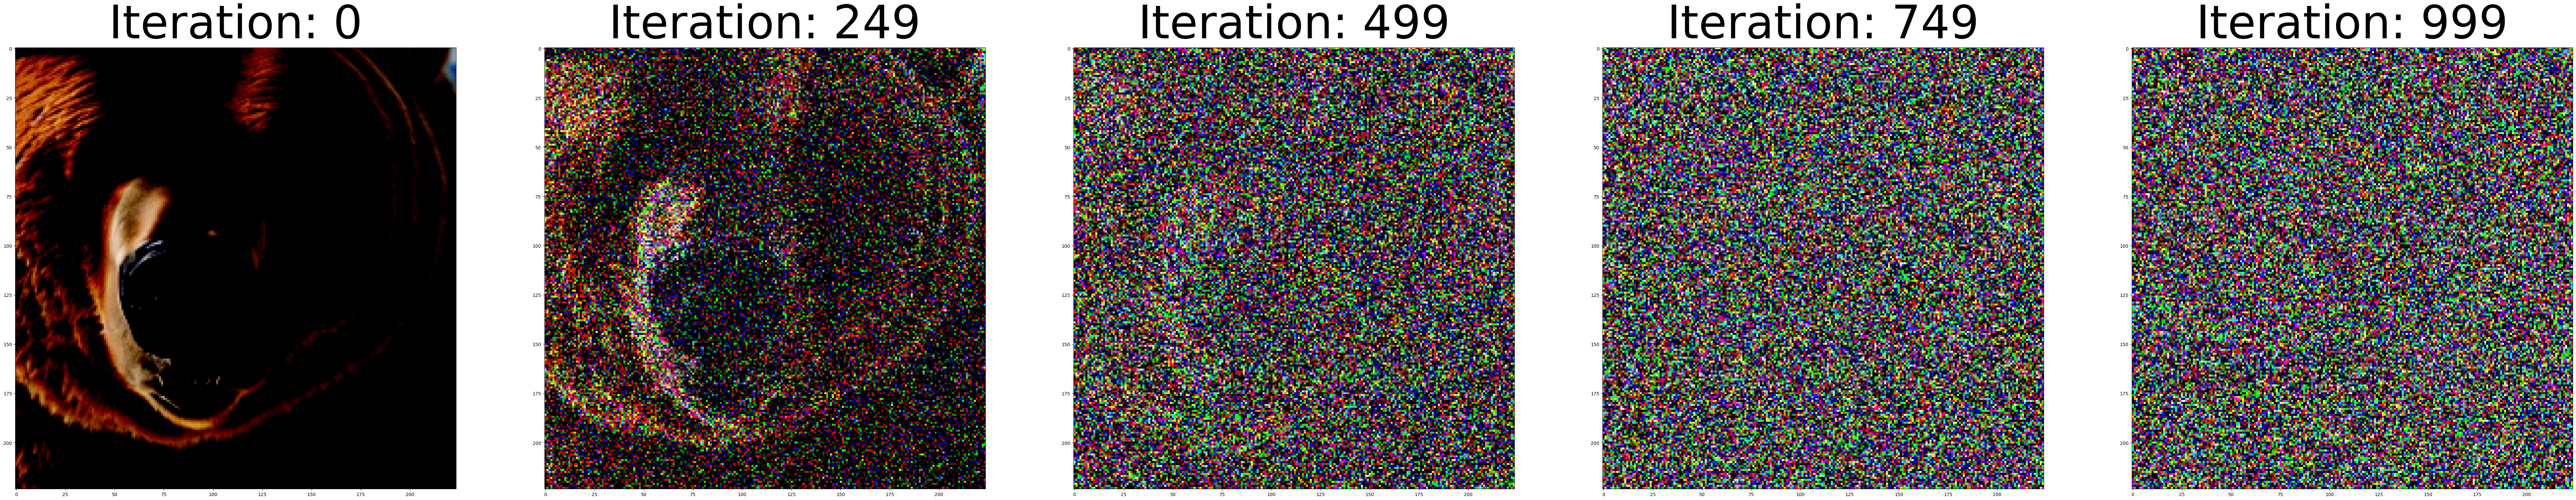

In [4]:
diffusion_model = DiffusionModel()
NO_DISPLAY_IMAGES=5
torch_image=train_dataset.__getitem__(0)[0]
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t,CFG['device'])
plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(image.cpu().detach().permute(1,2,0))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
plt.show()

# Sinusoidal Position Embedding

In [5]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim=dim

    def forward(self,time):
        device=time.device
        half_dim=self.dim//2
       
        embeddings=math.log(10000)/(half_dim-1)
        embeddings=torch.exp(torch.arange(half_dim,device=device)* -embeddings)
        embeddings=time[:,None]*embeddings[None,:]
        embeddings=torch.cat((embeddings.sin(),embeddings.cos()),dim=-1)
        return embeddings

In [6]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [7]:
class UNet(nn.Module):
    def __init__(self,img_channels=3,time_embedding_dims=128,labels=False,sequence_channels=(64,128,256,512,1024)):
        super().__init__()
        self.time_embedding_dims=time_embedding_dims
        sequence_channels_rev=reversed(sequence_channels)

        self.downsampling=nn.ModuleList([Block(channels_in,channels_out,time_embedding_dims,labels) for channels_in, channels_out in zip(sequence_channels,sequence_channels[1:])])
        self.upsampling=nn.ModuleList([Block(channels_in,channels_out,time_embedding_dims,labels,downsample=False) for channels_in,channels_out in zip(sequence_channels[::-1],sequence_channels[::-1][1:])])

        self.conv1=nn.Conv2d(img_channels,sequence_channels[0],3,padding=1)
        self.conv2=nn.Conv2d(sequence_channels[0],img_channels,1)


    def forward(self,x,t,**kwargs):
        residuals=[]
        o=self.conv1(x)

        for ds in self.downsampling:
            o=ds(o,t,**kwargs)
            residuals.append(o)

        for us,res in zip(self.upsampling,reversed(residuals)):
            o=us(torch.cat((o,res),dim=1),t,**kwargs)

        return self.conv2(o)

In [8]:
EPOCH=2000
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True
flag_loss=1000
criterion=nn.MSELoss()
device=torch.device(('cuda' if torch.cuda.is_available() else 'cpu'))
unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [9]:
t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

In [10]:
for epoch in range(EPOCH):
    mean_epoch_loss=[]
    for i,(images,labels) in enumerate(tqdm(train_loader)):
        images=images.to(device)
        labels=labels.to(device)
        t = torch.randint(0, diffusion_model.timesteps, (images.size(0),)).long().to(device)
        batch_noisy,noise=diffusion_model.forward(images,t,device)
        predictd_noise=unet(batch_noisy,t,labels=labels.reshape(-1,1).float())

        optimizer.zero_grad()
        loss=criterion(noise,predictd_noise)

        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()


    print('---')
    print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")





        

100%|██████████| 1250/1250 [04:16<00:00,  4.87it/s]


---
Epoch: 0 | Train Loss 0.07151154013574124


100%|██████████| 1250/1250 [03:58<00:00,  5.25it/s]


---
Epoch: 1 | Train Loss 0.038919861134141684


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 2 | Train Loss 0.03435574346780777


100%|██████████| 1250/1250 [03:58<00:00,  5.24it/s]


---
Epoch: 3 | Train Loss 0.031984778048098086


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 4 | Train Loss 0.030065502195432782


100%|██████████| 1250/1250 [03:58<00:00,  5.24it/s]


---
Epoch: 5 | Train Loss 0.028439242237061263


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 6 | Train Loss 0.02607883951086551


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 7 | Train Loss 0.026435752692446114


100%|██████████| 1250/1250 [03:59<00:00,  5.23it/s]


---
Epoch: 8 | Train Loss 0.026459310003742575


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 9 | Train Loss 0.02433243218678981


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 10 | Train Loss 0.02325167843773961


100%|██████████| 1250/1250 [03:58<00:00,  5.25it/s]


---
Epoch: 11 | Train Loss 0.02364703448675573


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 12 | Train Loss 0.02309580389428884


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 13 | Train Loss 0.022661642231605945


100%|██████████| 1250/1250 [03:57<00:00,  5.25it/s]


---
Epoch: 14 | Train Loss 0.021539907700568437


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 15 | Train Loss 0.02167134260199964


100%|██████████| 1250/1250 [03:58<00:00,  5.25it/s]


---
Epoch: 16 | Train Loss 0.021795109914243223


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 17 | Train Loss 0.021736904691439123


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 18 | Train Loss 0.021012605195492504


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 19 | Train Loss 0.020876968782488257


100%|██████████| 1250/1250 [03:58<00:00,  5.25it/s]


---
Epoch: 20 | Train Loss 0.020812287422828375


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 21 | Train Loss 0.020654484027065337


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 22 | Train Loss 0.021611231948528438


100%|██████████| 1250/1250 [03:56<00:00,  5.28it/s]


---
Epoch: 23 | Train Loss 0.021621658328268678


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 24 | Train Loss 0.02139776402413845


100%|██████████| 1250/1250 [03:57<00:00,  5.25it/s]


---
Epoch: 25 | Train Loss 0.02004018296226859


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 26 | Train Loss 0.021264733142126353


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 27 | Train Loss 0.020099439840670676


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 28 | Train Loss 0.02088631054274738


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 29 | Train Loss 0.01948825317248702


100%|██████████| 1250/1250 [03:58<00:00,  5.24it/s]


---
Epoch: 30 | Train Loss 0.020270556611288338


100%|██████████| 1250/1250 [03:57<00:00,  5.25it/s]


---
Epoch: 31 | Train Loss 0.020588145524729044


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 32 | Train Loss 0.01964178146123886


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 33 | Train Loss 0.019753289905190468


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 34 | Train Loss 0.019986310626380146


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 35 | Train Loss 0.02066400170372799


100%|██████████| 1250/1250 [03:56<00:00,  5.28it/s]


---
Epoch: 36 | Train Loss 0.019916922089643775


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 37 | Train Loss 0.01927402414176613


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 38 | Train Loss 0.019096736016031356


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 39 | Train Loss 0.019185124765709043


100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


---
Epoch: 40 | Train Loss 0.019710497337859123


100%|██████████| 1250/1250 [03:56<00:00,  5.27it/s]


---
Epoch: 41 | Train Loss 0.018854163023363797


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 42 | Train Loss 0.018705964795686304


100%|██████████| 1250/1250 [03:58<00:00,  5.25it/s]


---
Epoch: 43 | Train Loss 0.01837923612706363


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 44 | Train Loss 0.018669402919244023


100%|██████████| 1250/1250 [03:56<00:00,  5.28it/s]


---
Epoch: 45 | Train Loss 0.01934846633002162


100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


---
Epoch: 46 | Train Loss 0.01851464394722134


100%|██████████| 1250/1250 [03:56<00:00,  5.29it/s]


---
Epoch: 47 | Train Loss 0.018801104503311218


100%|██████████| 1250/1250 [03:56<00:00,  5.28it/s]


---
Epoch: 48 | Train Loss 0.019519688641279936


100%|██████████| 1250/1250 [03:57<00:00,  5.25it/s]


---
Epoch: 49 | Train Loss 0.019629890787415206


100%|██████████| 1250/1250 [03:56<00:00,  5.28it/s]


---
Epoch: 50 | Train Loss 0.01909121106863022


100%|██████████| 1250/1250 [04:00<00:00,  5.19it/s]


---
Epoch: 51 | Train Loss 0.018511312946956605


100%|██████████| 1250/1250 [04:04<00:00,  5.12it/s]


---
Epoch: 52 | Train Loss 0.01890471794512123


100%|██████████| 1250/1250 [04:02<00:00,  5.16it/s]


---
Epoch: 53 | Train Loss 0.018350641595385967


100%|██████████| 1250/1250 [04:02<00:00,  5.15it/s]


---
Epoch: 54 | Train Loss 0.01897589977942407


100%|██████████| 1250/1250 [04:02<00:00,  5.16it/s]


---
Epoch: 55 | Train Loss 0.01841665747994557


100%|██████████| 1250/1250 [04:05<00:00,  5.10it/s]


---
Epoch: 56 | Train Loss 0.018520318258367478


100%|██████████| 1250/1250 [04:14<00:00,  4.91it/s]


---
Epoch: 57 | Train Loss 0.019012018664134666


100%|██████████| 1250/1250 [04:13<00:00,  4.94it/s]


---
Epoch: 58 | Train Loss 0.01838601832985878


100%|██████████| 1250/1250 [04:16<00:00,  4.88it/s]


---
Epoch: 59 | Train Loss 0.019122044384386392


  2%|▏         | 26/1250 [00:05<04:26,  4.60it/s]


KeyboardInterrupt: 